In [843]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [844]:
homes = pd.read_csv("mlssales23-08-29.csv")
homes = homes.drop(columns=['Unnamed: 0', 'index'])

Create training data arrays and split into training, cross-validation, and test sets.

In [845]:
X_train = np.c_[homes['Beds'], homes['Baths'], homes['Square_Feet'], homes['Year_Built'], 
                homes['Garages'], homes['Lot_SqFt']]
y_train = np.array(homes['Price'])

In [846]:
x_training, x_, y_training, y_ = train_test_split(X_train, y_train, test_size=0.4, random_state=1)
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size = 0.5, random_state=1)
del x_, y_

Try a linear regression model and test its accuracy.

In [847]:
steps_linear = [
    ('scaler', StandardScaler()),
     ('lin_reg', LinearRegression())
]
pipe_linear = Pipeline(steps_linear)
model_linear = pipe_linear.fit(x_training, y_training)
yhat_linear = model_linear.predict(x_training)

In [848]:
print(f"rmse training: {np.sqrt(mean_squared_error(y_training, yhat_linear))},\
\nr2 training: {r2_score(y_training, yhat_linear)}")
print(f"rmse test: {np.sqrt(mean_squared_error(y_test, model_linear.predict(x_test)))},\
\nr2 test: {r2_score(y_test, model_linear.predict(x_test))}")
print(f"rmse cv: {np.sqrt(mean_squared_error(y_cv, model_linear.predict(x_cv)))},\
\nr2 cv: {r2_score(y_cv, model_linear.predict(x_cv))}")

rmse training: 133848.00247688568,
r2 training: 0.7786326594948263
rmse test: 146946.71596452975,
r2 test: 0.7682085117433861
rmse cv: 147146.05333401254,
r2 cv: 0.7638473293796797


A good start, but not super accurate.

Try polynomial regression to capture nonlinear relationships between the data. Calculate the value of alpha with the lowest CV error for an L2 regularized polynomial regression model.

In [877]:
train_mses_ridge = []
cv_mses_ridge = []
for a in np.arange(0, 50, 0.1):   
    steps = [('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(3, include_bias=False)),
            ('model', Ridge(alpha=a))]
    pipe = Pipeline(steps)
    model_ridge = pipe.fit(x_training, y_training)
    yhat = model_ridge.predict(x_training)
    train_mses_ridge.append(mean_squared_error(yhat, y_training))
    yhat = model_ridge.predict(x_cv)
    cv_mses_ridge.append(mean_squared_error(yhat, y_cv))

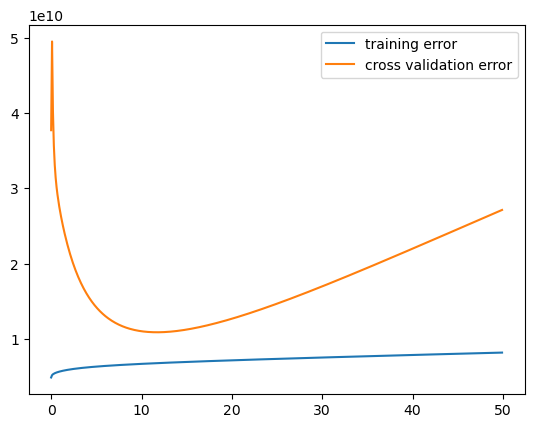

In [878]:
plt.plot(np.arange(0, 50, 0.1), train_mses_ridge)
plt.plot(np.arange(0, 50, 0.1), cv_mses_ridge)
plt.legend(['training error', 'cross validation error'])

In [883]:
alpha = np.argmin(np.array(cv_mses_ridge)) / 10
alpha

11.7

Implement an L2 regularized regression model with the alpha value found above and determine its accuracy.

In [902]:
steps_ridge = [('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(3, include_bias=False)),
        ('model', Ridge(alpha=alpha))]
pipe_ridge = Pipeline(steps_ridge)
model_ridge = pipe_ridge.fit(x_training, y_training)

In [903]:
print(f"rmse training: {np.sqrt(mean_squared_error(y_training, model_ridge.predict(x_training)))},\
\nr2 training: {r2_score(y_training, model_ridge.predict(x_training))}")
print(f"rmse test: {np.sqrt(mean_squared_error(y_test, model_ridge.predict(x_test)))},\
\nr2 test: {r2_score(y_test, model_ridge.predict(x_test))}")
print(f"rmse cv: {np.sqrt(mean_squared_error(y_cv, model_ridge.predict(x_cv)))},\
\nr2 cv: {r2_score(y_cv, model_ridge.predict(x_cv))}")

rmse training: 82612.5583485361,
r2 training: 0.9156700384599326
rmse test: 111097.19997984878,
r2 test: 0.867509743349835
rmse cv: 104503.85754997756,
r2 cv: 0.8808866967599196


This model seems to be much more accurate than the linear regression model.

Try a gradient boosted regression model.

In [887]:
steps_boost = [('scaler', StandardScaler()),
        ('boost', XGBRegressor())]
pipe_boost = Pipeline(steps_boost)
model_boost = pipe_boost.fit(x_training, y_training)

In [888]:
print(f"mse training: {mean_squared_error(y_training, yhat_boost)},\
\nr2 training: {r2_score(y_training, yhat_boost)}")
print(f"mse test: {mean_squared_error(y_test, model_boost.predict(x_test))},\
\nr2 test: {r2_score(y_test, model_boost.predict(x_test))}")
print(f"mse cv: {mean_squared_error(y_cv, model_boost.predict(x_cv))},\
\nr2 cv: {r2_score(y_cv, model_boost.predict(x_cv))}")

mse training: 52961562.65999614,
r2 training: 0.9993455890618401
mse test: 11392938325.897957,
r2 test: 0.877703659722425
mse cv: 15691397477.498472,
r2 cv: 0.8288577455842989


Seems to be prone to overfitting. Try tuning hyperparameters to reduce overfit.

In [890]:
search_space = {
    "boost__reg_lambda": [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    "boost__gamma": [0, 0.01, 0.05, 0.1, 0.5, 1],
    "boost__max_depth": range(1, 21),
    "boost__learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1],
    "boost__min_child_weight": range(1, 21)
}

In [907]:
rs = RandomizedSearchCV(
    estimator=model_boost,
    param_distributions=search_space,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="r2",
    verbose=4,
    n_iter=100
)

In [920]:
rs.fit(x_training, y_training)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=20, boost__min_child_weight=2, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-703793.472) r2: (test=-8.662) total time=   0.3s
[CV 2/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=20, boost__min_child_weight=2, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-751125.432) r2: (test=-4.319) total time=   0.1s
[CV 3/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=20, boost__min_child_weight=2, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-691524.006) r2: (test=-4.634) total time=   0.1s
[CV 4/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=20, boost__min_child_weight=2, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-687665.597) r2: (test=-4.916) total time=   0.1s
[CV 5/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=20, boost__

[CV 5/5] END boost__gamma=0.1, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=4, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-127385.023) r2: (test=0.797) total time=   0.2s
[CV 1/5] END boost__gamma=0.01, boost__learning_rate=0.005, boost__max_depth=19, boost__min_child_weight=10, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-482314.598) r2: (test=-3.538) total time=   0.0s
[CV 2/5] END boost__gamma=0.01, boost__learning_rate=0.005, boost__max_depth=19, boost__min_child_weight=10, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-544311.642) r2: (test=-1.793) total time=   0.0s
[CV 3/5] END boost__gamma=0.01, boost__learning_rate=0.005, boost__max_depth=19, boost__min_child_weight=10, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-483435.502) r2: (test=-1.754) total time=   0.0s
[CV 4/5] END boost__gamma=0.01, boost__learning_rate=0.005, boost__max_depth=19, boost__min_child_weight=10, boost__reg_lambda=5; neg_root_mean

[CV 1/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=7, boost__min_child_weight=1, boost__reg_lambda=0.01; neg_root_mean_squared_error: (test=-288254.256) r2: (test=-0.621) total time=   0.2s
[CV 2/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=7, boost__min_child_weight=1, boost__reg_lambda=0.01; neg_root_mean_squared_error: (test=-340204.861) r2: (test=-0.091) total time=   0.1s
[CV 3/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=7, boost__min_child_weight=1, boost__reg_lambda=0.01; neg_root_mean_squared_error: (test=-275842.808) r2: (test=0.103) total time=   0.1s
[CV 4/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=7, boost__min_child_weight=1, boost__reg_lambda=0.01; neg_root_mean_squared_error: (test=-287885.824) r2: (test=-0.037) total time=   0.1s
[CV 5/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=7, boost__min_child_weight=1, boost__reg_lambda=0.01; neg_root_mean_sq

[CV 1/5] END boost__gamma=0, boost__learning_rate=0.005, boost__max_depth=8, boost__min_child_weight=2, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-471765.860) r2: (test=-3.342) total time=   0.1s
[CV 2/5] END boost__gamma=0, boost__learning_rate=0.005, boost__max_depth=8, boost__min_child_weight=2, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-517382.463) r2: (test=-1.524) total time=   0.1s
[CV 3/5] END boost__gamma=0, boost__learning_rate=0.005, boost__max_depth=8, boost__min_child_weight=2, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-459442.837) r2: (test=-1.487) total time=   0.1s
[CV 4/5] END boost__gamma=0, boost__learning_rate=0.005, boost__max_depth=8, boost__min_child_weight=2, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-462213.963) r2: (test=-1.673) total time=   0.1s
[CV 5/5] END boost__gamma=0, boost__learning_rate=0.005, boost__max_depth=8, boost__min_child_weight=2, boost__reg_lambda=0.05; neg_root_mean_square

[CV 2/5] END boost__gamma=0.1, boost__learning_rate=0.1, boost__max_depth=16, boost__min_child_weight=15, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-104536.396) r2: (test=0.897) total time=   0.1s
[CV 3/5] END boost__gamma=0.1, boost__learning_rate=0.1, boost__max_depth=16, boost__min_child_weight=15, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-80212.363) r2: (test=0.924) total time=   0.1s
[CV 4/5] END boost__gamma=0.1, boost__learning_rate=0.1, boost__max_depth=16, boost__min_child_weight=15, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-108618.555) r2: (test=0.852) total time=   0.1s
[CV 5/5] END boost__gamma=0.1, boost__learning_rate=0.1, boost__max_depth=16, boost__min_child_weight=15, boost__reg_lambda=0.05; neg_root_mean_squared_error: (test=-107902.325) r2: (test=0.855) total time=   0.1s
[CV 1/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=18, boost__min_child_weight=15, boost__reg_lambda=10; neg_root_mean_squ

[CV 1/5] END boost__gamma=0.05, boost__learning_rate=0.001, boost__max_depth=10, boost__min_child_weight=18, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-709838.867) r2: (test=-8.829) total time=   0.1s
[CV 2/5] END boost__gamma=0.05, boost__learning_rate=0.001, boost__max_depth=10, boost__min_child_weight=18, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-759994.320) r2: (test=-4.445) total time=   0.0s
[CV 3/5] END boost__gamma=0.05, boost__learning_rate=0.001, boost__max_depth=10, boost__min_child_weight=18, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-699614.964) r2: (test=-4.767) total time=   0.0s
[CV 4/5] END boost__gamma=0.05, boost__learning_rate=0.001, boost__max_depth=10, boost__min_child_weight=18, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-693159.980) r2: (test=-5.011) total time=   0.0s
[CV 5/5] END boost__gamma=0.05, boost__learning_rate=0.001, boost__max_depth=10, boost__min_child_weight=18, boost__reg_lambda=10; neg_r

[CV 3/5] END boost__gamma=1, boost__learning_rate=0.5, boost__max_depth=2, boost__min_child_weight=15, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-93555.357) r2: (test=0.897) total time=   0.1s
[CV 4/5] END boost__gamma=1, boost__learning_rate=0.5, boost__max_depth=2, boost__min_child_weight=15, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-99437.971) r2: (test=0.876) total time=   0.0s
[CV 5/5] END boost__gamma=1, boost__learning_rate=0.5, boost__max_depth=2, boost__min_child_weight=15, boost__reg_lambda=10; neg_root_mean_squared_error: (test=-109816.476) r2: (test=0.849) total time=   0.0s
[CV 1/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=1, boost__min_child_weight=17, boost__reg_lambda=0.5; neg_root_mean_squared_error: (test=-309378.138) r2: (test=-0.867) total time=   0.0s
[CV 2/5] END boost__gamma=0.5, boost__learning_rate=0.01, boost__max_depth=1, boost__min_child_weight=17, boost__reg_lambda=0.5; neg_root_mean_squared_error: (te

[CV 3/5] END boost__gamma=0.01, boost__learning_rate=0.5, boost__max_depth=1, boost__min_child_weight=5, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-115002.436) r2: (test=0.844) total time=   0.0s
[CV 4/5] END boost__gamma=0.01, boost__learning_rate=0.5, boost__max_depth=1, boost__min_child_weight=5, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-108177.375) r2: (test=0.854) total time=   0.0s
[CV 5/5] END boost__gamma=0.01, boost__learning_rate=0.5, boost__max_depth=1, boost__min_child_weight=5, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-118315.393) r2: (test=0.825) total time=   0.1s
[CV 1/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=18, boost__min_child_weight=10, boost__reg_lambda=0; neg_root_mean_squared_error: (test=-89440.417) r2: (test=0.844) total time=   2.2s
[CV 2/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=18, boost__min_child_weight=10, boost__reg_lambda=0; neg_root_mean_squared_error: (test=-1

[CV 2/5] END boost__gamma=0.5, boost__learning_rate=1, boost__max_depth=16, boost__min_child_weight=7, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-143980.952) r2: (test=0.805) total time=   0.2s
[CV 3/5] END boost__gamma=0.5, boost__learning_rate=1, boost__max_depth=16, boost__min_child_weight=7, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-120474.857) r2: (test=0.829) total time=   0.3s
[CV 4/5] END boost__gamma=0.5, boost__learning_rate=1, boost__max_depth=16, boost__min_child_weight=7, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-116021.559) r2: (test=0.832) total time=   0.3s
[CV 5/5] END boost__gamma=0.5, boost__learning_rate=1, boost__max_depth=16, boost__min_child_weight=7, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-104239.349) r2: (test=0.864) total time=   0.1s
[CV 1/5] END boost__gamma=1, boost__learning_rate=0.005, boost__max_depth=13, boost__min_child_weight=13, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-468

[CV 1/5] END boost__gamma=0.5, boost__learning_rate=0.05, boost__max_depth=15, boost__min_child_weight=3, boost__reg_lambda=0.5; neg_root_mean_squared_error: (test=-95564.562) r2: (test=0.822) total time=   0.1s
[CV 2/5] END boost__gamma=0.5, boost__learning_rate=0.05, boost__max_depth=15, boost__min_child_weight=3, boost__reg_lambda=0.5; neg_root_mean_squared_error: (test=-107962.231) r2: (test=0.890) total time=   0.1s
[CV 3/5] END boost__gamma=0.5, boost__learning_rate=0.05, boost__max_depth=15, boost__min_child_weight=3, boost__reg_lambda=0.5; neg_root_mean_squared_error: (test=-94999.905) r2: (test=0.894) total time=   0.1s
[CV 4/5] END boost__gamma=0.5, boost__learning_rate=0.05, boost__max_depth=15, boost__min_child_weight=3, boost__reg_lambda=0.5; neg_root_mean_squared_error: (test=-93591.152) r2: (test=0.890) total time=   0.1s
[CV 5/5] END boost__gamma=0.5, boost__learning_rate=0.05, boost__max_depth=15, boost__min_child_weight=3, boost__reg_lambda=0.5; neg_root_mean_squared_

[CV 2/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=20, boost__min_child_weight=15, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-112043.559) r2: (test=0.882) total time=   0.1s
[CV 3/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=20, boost__min_child_weight=15, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-85420.361) r2: (test=0.914) total time=   0.1s
[CV 4/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=20, boost__min_child_weight=15, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-101570.451) r2: (test=0.871) total time=   0.1s
[CV 5/5] END boost__gamma=1, boost__learning_rate=0.3, boost__max_depth=20, boost__min_child_weight=15, boost__reg_lambda=5; neg_root_mean_squared_error: (test=-101399.560) r2: (test=0.872) total time=   0.1s
[CV 1/5] END boost__gamma=1, boost__learning_rate=0.001, boost__max_depth=18, boost__min_child_weight=14, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-

[CV 1/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=12, boost__min_child_weight=6, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-108490.071) r2: (test=0.770) total time=   0.1s
[CV 2/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=12, boost__min_child_weight=6, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-119068.914) r2: (test=0.866) total time=   0.1s
[CV 3/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=12, boost__min_child_weight=6, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-94565.298) r2: (test=0.895) total time=   0.1s
[CV 4/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=12, boost__min_child_weight=6, boost__reg_lambda=0.1; neg_root_mean_squared_error: (test=-100964.932) r2: (test=0.872) total time=   0.1s
[CV 5/5] END boost__gamma=0.5, boost__learning_rate=0.3, boost__max_depth=12, boost__min_child_weight=6, boost__reg_lambda=0.1; neg_root_mean_squared_err

[CV 1/5] END boost__gamma=0.05, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=18, boost__reg_lambda=1; neg_root_mean_squared_error: (test=-88649.665) r2: (test=0.847) total time=   0.2s
[CV 2/5] END boost__gamma=0.05, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=18, boost__reg_lambda=1; neg_root_mean_squared_error: (test=-107665.367) r2: (test=0.891) total time=   0.5s
[CV 3/5] END boost__gamma=0.05, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=18, boost__reg_lambda=1; neg_root_mean_squared_error: (test=-91861.830) r2: (test=0.901) total time=   0.2s
[CV 4/5] END boost__gamma=0.05, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=18, boost__reg_lambda=1; neg_root_mean_squared_error: (test=-95785.665) r2: (test=0.885) total time=   0.2s
[CV 5/5] END boost__gamma=0.05, boost__learning_rate=0.3, boost__max_depth=14, boost__min_child_weight=18, boost__reg_lambda=1; neg_root_mean_squared_error

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('boost',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importance_type=...
                                                           predictor=None,
                                                           random_state=None, ...))]),
                   n_iter=100,
                   param_distributions={'boost__gamma': [0, 0.01, 0.05, 0.1,
                                                         0.5, 1],
                                        'boost__learning_rate': [0.001, 0.005,
                                                                 0.01, 0.05,
                                                                 0.1, 0.3, 0.5,
                                                                 1],
                                        'boost__max_depth': range(1, 21),
                                        'boost__min_child_weight': range(1, 21),
                                        'boost__reg_lambda': [0, 0.01, 0.05,
                                                              0.1, 0.5, 1, 5,
                                                              10]},
                   refit='r2', scoring=['neg_root_mean_squared_error', 'r2'],
                   verbose=4)

In [921]:
rs.best_params_

{'boost__reg_lambda': 0,
 'boost__min_child_weight': 18,
 'boost__max_depth': 5,
 'boost__learning_rate': 0.1,
 'boost__gamma': 0}

In [922]:
boost_tuned = XGBRegressor(
    reg_lambda=0,
    min_child_weight=18,
    max_depth=5,
    learning_rate=0.1,
    gamma=0
)
model_boost_tuned = boost_tuned.fit(x_training, y_training)

In [923]:
print(f"rmse training: {np.sqrt(mean_squared_error(y_training, model_boost_tuned.predict(x_training)))},\
\nr2 training: {r2_score(y_training, model_boost_tuned.predict(x_training))}")
print(f"rmse test: {np.sqrt(mean_squared_error(y_test, model_boost_tuned.predict(x_test)))},\
\nr2 test: {r2_score(y_test, model_boost_tuned.predict(x_test))}")
print(f"rmse cv: {np.sqrt(mean_squared_error(y_cv, model_boost_tuned.predict(x_cv)))},\
\nr2 cv: {r2_score(y_cv, model_boost_tuned.predict(x_cv))}")

rmse training: 58212.84172976089,
r2 training: 0.9581276476494361
rmse test: 117430.95909937036,
r2 test: 0.8519723207453831
rmse cv: 123052.20023242457,
r2 cv: 0.8348515918474848


Compare the four different models.

In [924]:
print("Test")
print(f"Linear: {r2_score(y_test, model_linear.predict(x_test))}")
print(f"Regularized: {r2_score(y_test, model_ridge.predict(x_test))}")
print(f"XGBoost: {r2_score(y_test, model_boost.predict(x_test))}")
print(f"XGBoost Tuned: {r2_score(y_test, model_boost_tuned.predict(x_test))}")

Test
Linear: 0.7682085117433861
Regularized: 0.867509743349835
XGBoost: 0.877703659722425
XGBoost Tuned: 0.8519723207453831


In [925]:
print("CV")
print(f"Linear: {r2_score(y_cv, model_linear.predict(x_cv))}")
print(f"Regularized: {r2_score(y_cv, model_ridge.predict(x_cv))}")
print(f"XGBoost: {r2_score(y_cv, model_boost.predict(x_cv))}")
print(f"XGBoost Tuned: {r2_score(y_cv, model_boost_tuned.predict(x_cv))}")

CV
Linear: 0.7638473293796797
Regularized: 0.8808866967599196
XGBoost: 0.8288577455842989
XGBoost Tuned: 0.8348515918474848


In [926]:
print("Training")
print(f"Linear: {r2_score(y_training, model_linear.predict(x_training))}")
print(f"Regularized: {r2_score(y_training, model_ridge.predict(x_training))}")
print(f"XGBoost: {r2_score(y_training, model_boost.predict(x_training))}")
print(f"XGBoost Tuned: {r2_score(y_training, model_boost_tuned.predict(x_training))}")

Training
Linear: 0.7786326594948263
Regularized: 0.9156700384599326
XGBoost: 0.9993455890618401
XGBoost Tuned: 0.9581276476494361


Will select the regularized polynomial regression model due to very similar r2 scores to XGBoost models in the test group but much less overfitting.